## Inverse Goldstein Taylor model

Consider the macroscopic formulation of Goldstein-Taylor model in discrete velocity kinetic theory, i.e.

$$\partial_{t}\rho + \partial_{x}j = 0$$

$$\partial_{t}j + {(\frac{c}{\epsilon})}^2\partial_{x}\rho = - \frac{\sigma}{\epsilon^2}j$$

with $x \in \mathbb{R}, t \geq 0,$

$\rho = \rho(x, t)$ total particles density, $j = j(x, t)$ scaled flux, 

$\epsilon$ scaling parameter of the kinetic dynamics and $\sigma$ scattering coefficient.

#### Install libraries

In [1]:
!pip install hydra-core --upgrade
!pip install rootutils
!pip install --upgrade pyDOE
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=45c14c3b255d10b568bf80acb313d8d59ed9bd22c2bcfa0b3616bc991913b8d6
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1

In [2]:
import sys
# paths for Github link
package_paths = [
    '/kaggle/input/pdesolver/',
    '/kaggle/input/custompinnstorch/'
]

for pth in package_paths:
    sys.path.append(pth)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from typing import Dict
import torch
import random
import lightning.pytorch as pl
# import the solver
from Euler_IMEX import solve_E_I
# import Physics-Informed Neural Networks library in Pytorch
import pinnstorch

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
# clear output
#!rm -rf /kaggle/working/*

Let $x \in [-1,1],\,\, t \in [0,0.1]$.

In [6]:
m = 400 # discretization for x
n = 7000 # discretization for t
x_disc = np.linspace(-1,1,m+1)
t_disc = np.linspace(0,0.1,n+1)
delta_x = (x_disc[-1] - x_disc[0])/(len(x_disc)-1)
delta_t = (t_disc[-1] - t_disc[0])/(len(t_disc)-1)
print(f"Δx = {delta_x}")
print(f"Δx**2 = {(delta_x)**2}")
print(f"Δt = {delta_t}")

Δx = 0.005
Δx**2 = 2.5e-05
Δt = 1.4285714285714287e-05


#### Initial Condition



Let's start with initial condition of the model.

$$ \rho(x,\, 0) = 6 + 3\cos(3\pi x)$$

$$ j(x,\, 0) = \frac{9\pi c^2}{\sigma}\sin(3\pi x) $$

In [7]:
c = 1
sigma = 4
eps = 1e-4
rho_0 = 6+3*np.cos(3*np.pi*x_disc)
j_0 = (9*np.pi*(c**2)/sigma)*np.sin(3*np.pi*x_disc)

In [8]:
rho_tot, j_tot = solve_E_I(x_disc, t_disc, rho_0, j_0, eps, sigma, c)

In [9]:
T, X = np.meshgrid(t_disc, x_disc)

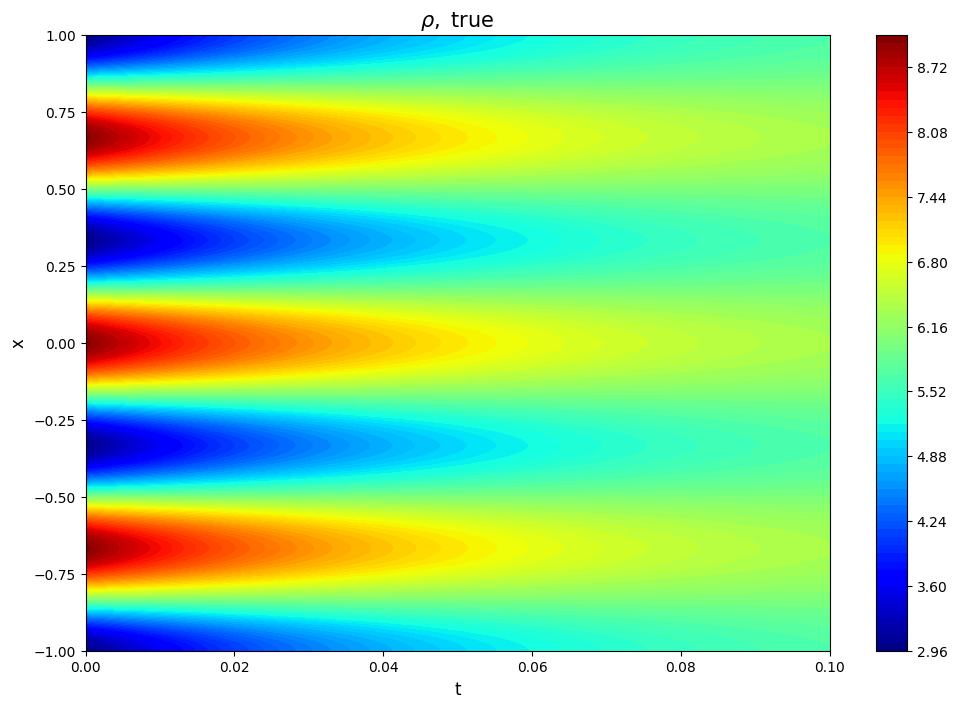

In [10]:
# rho
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, rho_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$\rho,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_rho.jpg', dpi=300)

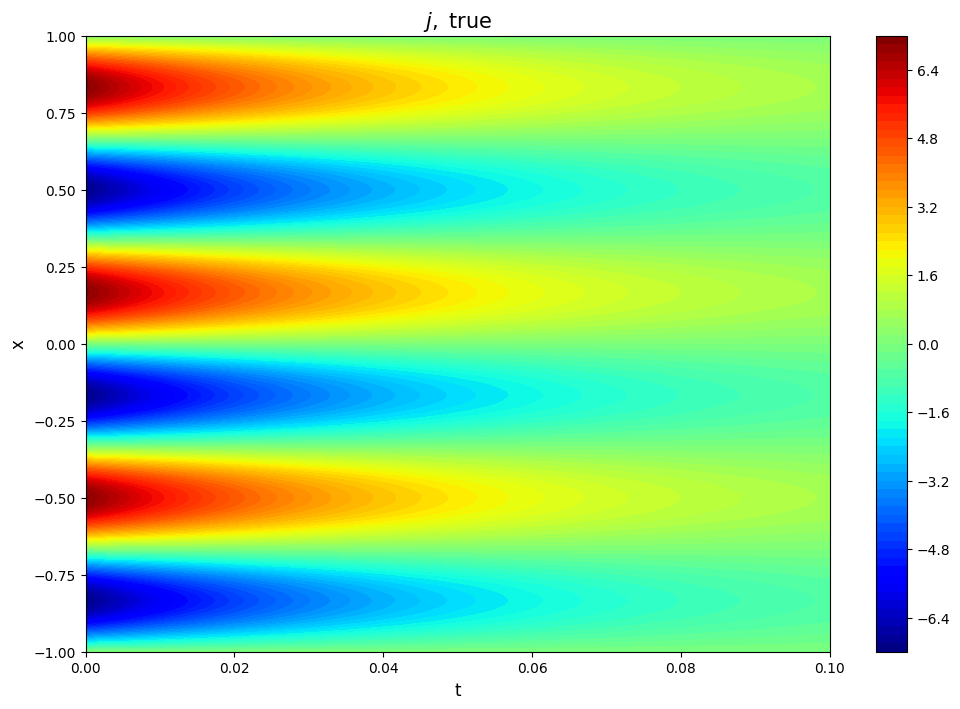

In [11]:
# j
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, j_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$j,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_j.jpg', dpi=300)

In [12]:
mdic = {"rho": rho_tot, "j": j_tot, "x": x_disc, "tt": t_disc}
savemat("GT.mat", mdic)

In [13]:
np.shape(rho_tot)

(401, 7001)

In [14]:
np.shape(j_tot)

(401, 7001)

In [15]:
np.shape(x_disc)

(401,)

### Define Mesh



Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnstorch`, there are primarily two approaches to define this mesh:





- **Defining Time and Spatial Domains Separately:** Here, we use `pinnstorch.data.TimeDomain` and `pinnstorch.data.Interval` for creating 1-D spatial domains. These domains are then used to define a `pinnstorch.data.Mesh`.



- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnstorch.data.PointCloud`.



Both approaches should ideally yield the same results.

In [17]:
def read_data_fn(root_path):

    """Read and preprocess data from the specified root path.



    :param root_path: The root directory containing the data.

    :return: Processed data will be used in PointCloud class.

    """



    data = pinnstorch.utils.load_data(root_path, "GT.mat")



    x = data["x"].T  # N x 1

    t = data["tt"].T  # T x 1


    exact_rho = data["rho"] # N x T
    

    exact_j = data["j"] # N x T



    return pinnstorch.data.PointCloudData(

            spatial=[x], time=[t], solution={"rho": exact_rho, "j": exact_j}

    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [18]:
mesh = pinnstorch.data.PointCloud(root_dir='/kaggle/working/',

                                  read_data_fn=read_data_fn)

### Define Train datasets

For solving Goldstein Taylor PDE, we must have:

- Initial conditions

- Periodic boundary conditions

- Collection points for the PDE.

#### Initial Condition



Let's start with initial condition of the model.

$$ \rho(x,\, 0) = 6 + 3\cos(3\pi x)$$

$$ j(x,\, 0) = \frac{9\pi c^2}{\sigma}\sin(3\pi x) $$



For defining initial condition, again we have two options.



- **Sample from the data.**

- **Defining a function for calculating initial condition.**

##### Set number of samples

In [19]:
N0 = 200

##### Sample from data

In [20]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,

                                        num_sample = N0,

                                        solution = ['rho', 'j'])

#### Periodic Boundary Condition

The `pinnstorch.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Goldstein Taylor equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.





$$ \rho(-1,t) = \rho(1, t), $$

$$ j(-1, t) = j(1, t), $$

$$ \rho_x(-1, t) = \rho_x(1, t),$$

$$ j_x(-1, t) = j_x(1, t) $$

In [21]:
N_b = 3000

pe_b = pinnstorch.data.PeriodicBoundaryCondition(mesh = mesh,

                                                 num_sample = N_b,

                                                 derivative_order = 1,

                                                 solution = ['rho'])

#### Mesh Sampler for collection points and solutions



In our problem, the partial differential equations (PDEs) governing the dynamics are given by:



$$f_{\rho} = \partial_{t}\rho + \partial_{x}j$$

$$f_j = \partial_{t}j + {(\frac{c}{\epsilon})}^2\partial_{x}\rho + \frac{\sigma}{\epsilon^2}j$$



To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstorch.data.MeshSampler` for this purpose, specifying the following:



- **Number of Sample Points (N_f):** We choose to sample 25,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.

- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.

- **Collection Points:** We define `['f_rho', 'f_j']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.



Here's the code to implement this sampler:

In [22]:
N_f = 25000

me_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                   num_sample = N_f,

                                   collection_points = ['f_rho', 'f_j'])

me_s2 = pinnstorch.data.MeshSampler(mesh = mesh,

                                   num_sample = N_f,

                                   solution =  ['rho'])


### Define Validation dataset



For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `rho` and `j`.



**Note:** If `num_sample` is not specified, the sampler will use the entire mesh for data sampling.

In [23]:
val_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                    solution = ['rho', 'j'],
                                   
                                    num_sample = 5000)

### Define Neural Networks



Here, we try to define a neural network for solving the problem. For defining a neural network, we should set number of layers and the name of the outputs. Also, domain bounds should be defined. The `lb` and `ub` parameters represent the lower and upper bounds of the spatial-temporal domain, helping in normalizing inputs to the network. Therefore, the inputs of this network are `x` and `t`, and the outputs of this network are `rho` and `j`.

In [24]:
net = pinnstorch.models.FCN(layers = [2, 100, 100, 100, 2],

                            output_names = ['rho', 'j'],

                            lb=mesh.lb,

                            ub=mesh.ub)

### Define `pde_fn` and `output_fn` functions



Now, we define `pde_fn` and `output_fn`.

- **`output_fn`:** is applied to the network's output, adding any necessary post-processing computations.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points.

#### `pde_fn` function



The inputs are similar to `output_fn`. Only if we have extra variables for training (i.g. in inverse problems), we should add input at the end of inputs. For example, `(outputs, x, t)` will be `(outputs, x, t, extra_variable)`. `extra_variable` is always a dictionary.

In [25]:
def pde_fn(outputs: Dict[str, torch.Tensor],

           x: torch.Tensor,

           t: torch.Tensor,
          
           extra_variables: Dict[str, torch.Tensor]):

    """Define the partial differential equations (PDEs)."""

    rho_x, rho_t = pinnstorch.utils.gradient(outputs["rho"], [x, t])

    j_x, j_t = pinnstorch.utils.gradient(outputs["j"], [x, t])



    #rho_xx = pinnstorch.utils.gradient(rho_x, x)[0]

    #j_xx = pinnstorch.utils.gradient(j_x, x)[0]



    outputs["f_rho"] = rho_t + j_x

    outputs["f_j"] = (1e-4**2) * j_t + (1**2)* rho_x + extra_variables["sigma"] * outputs["j"]



    return outputs

### Define PINNDataModule and PINNModule



To integrate with Lightning, we utilize two specialized modules:



- `PINNDataModule` (inherited from `LightningDataModule`) manages data.

- `PINNModule` (derived from `LightningModule`) handles the model, compilation, and various enhancements like AMP.

#### Define `PINNDataModule`

Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [26]:
val_dataset = val_s

datamodule = pinnstorch.data.PINNDataModule(train_datasets = [me_s, me_s2, in_c, pe_b],

                                            val_dataset = val_dataset,

                                            pred_dataset = val_s)

#### Define `PINNModule`



`PINNModule` handle several things. Here, we will explore the inputs of this class:

- **net:**  The neural network.

- **pde_fn:** The function representing the PDE to solve.

- **optimizer:**  (Optional) The optimizer for training. The default is Adam

- **loss_fn:** (Optional) The loss function to use, either "sse" or "mse". The default is "sse".

- **scheduler:** (Optional) Learning rate scheduler. The default is None.

- **scaler:** (Optional) Gradient scaler for AMP. The default is `torch.cuda.amp.GradScaler`.

- **extra_variables:** (Optional) Extra variables in inverse problems. The default is None.

- **output_fn:** (Optional) function to process the model's output. The default is None.

- **runge_kutta:** (Optional) Runge-Kutta method for solving PDEs in discrete mode. The default is None.

- **cudagraph_compile:** Flag to enable CUDA Graph compilation. It works only with a single GPU. The default is True.

- **jit_compile:** (Optional) Flag to enable JIT compilation. The default is True.

- **amp:** (Optional) Flag to enable Automatic Mixed Precision (AMP). The default is False.

- **inline:** (Optional) Flag to enable inline mode in JIT compilation. The default is False.



In this example, we initalize `PINNModule` with defined variables. We set Adam optimizer and try to compile the model with CUDA Graph. The loss function here is Mean Square Error (MSE).

In [27]:
model = pinnstorch.models.PINNModule(net = net,

                                     pde_fn = pde_fn,

                                     loss_fn = 'mse',
                                    
                                     extra_variables={"sigma": 2.0})
                                 

### Setting Up the Trainer



For training our model, we configure a trainer in PyTorch Lightning. Currently, our setup uses a single GPU, as models compiled with CUDA Graph don't support multiple GPUs yet. For a comprehensive understanding of the trainer's options and functionalities, refer to the [official documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html). For example, arguments that you can set are:

- **accelerator:**  Supports passing different accelerator types such as `cpu`, `gpu`, `tpu`, `ipu`, `hpu`, `mps`, and `auto`.

- **devices:** The devices to use. Can be set to a positive number (int or str), a sequence of device indices (list or str), the value -1 to indicate all available devices should be used, or "auto" for automatic selection based on the chosen accelerator. Default: "auto".

- **max_epochs:** Stop training once this number of epochs is reached.

- **max_steps:** Stop training after this number of steps.

- ...



In our example, we configure the trainer for GPU use, specifying one device:

In [28]:
from lightning.pytorch import seed_everything

seed_everything(seed, workers=True)

INFO: Seed set to 42


42

In [29]:
from lightning.pytorch.loggers import CSVLogger

# Create a CSVLogger instance
logger = CSVLogger(save_dir="logs", name="exp")

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = 20000, check_val_every_n_epoch = 20001, precision=64, deterministic=True, logger=logger)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model=model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | net             | FCN           | 20.7 K | train
1 | extra_variables | ParameterDict | 1      | train
2 | train_loss      | MeanMetric    | 0      | train
3 | val_loss        | MeanMetric    | 0      | train
4 | val_error       | MeanMetric    | 0      | train
5 | test_loss       | MeanMetric    | 0      | train
6 | test_error      | MeanMetric    | 0      | train
7 | val_loss_best   | MinMetric     | 0      | train
----------------------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you ac

Plot $\sigma$ versus epoch

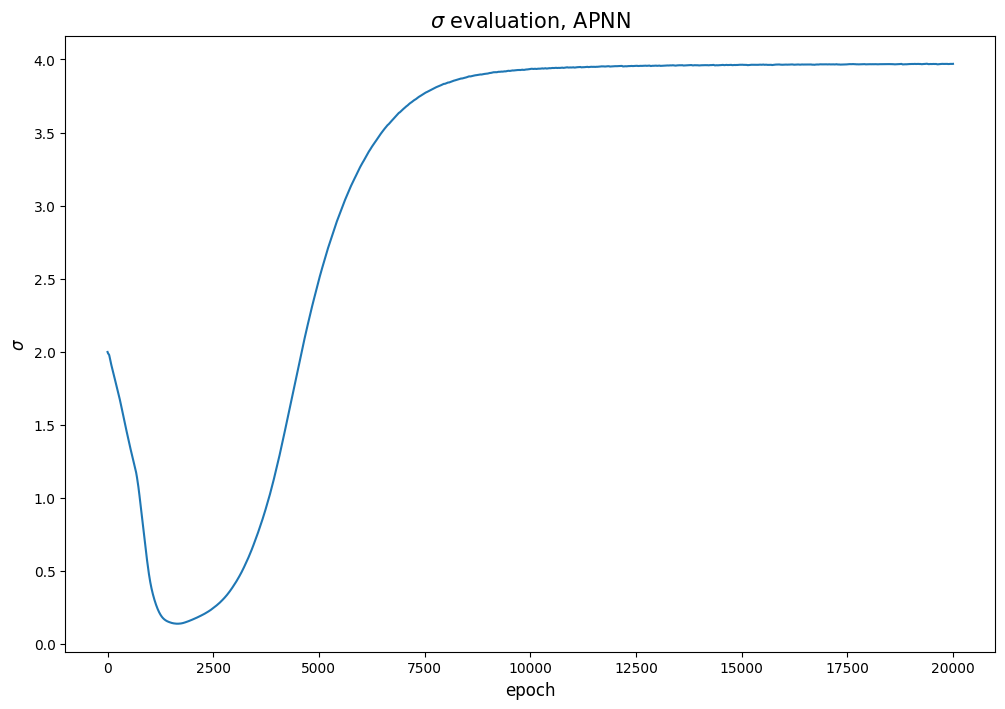

In [31]:
import pandas as pd

df = pd.read_csv("/kaggle/working/logs/exp/version_0/metrics.csv") # get the .csv log file from training

df = df[['epoch', 'sigma']]

df.dropna(inplace=True) # drop NaN values

fig=plt.figure(figsize=(12,8), dpi= 100)

plt.plot(df['epoch'].values, df['sigma'].values)
plt.title(r'$\sigma$ evaluation, APNN',      
          fontsize="15", wrap=True)
plt.xlabel(r'epoch', fontsize="12")
plt.ylabel(r'$\sigma$', fontsize="12")  
fig.savefig('sigma_epoch.jpg', dpi=300)
plt.show()